# Explore here

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from sklearn.exceptions import ConvergenceWarning

# Ignore cognigence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [44]:
df = pd.read_csv("../data/raw/medical_insurance_cost.csv")

df

,Unnamed: 0,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1333,1333,50,male,30.970,3,no,northwest,10600.54830
1334,1334,18,female,31.920,0,no,northeast,2205.98080
1335,1335,18,female,36.850,0,no,southeast,1629.83350
1336,1336,21,female,25.800,0,no,southwest,2007.94500


In [45]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [47]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

1


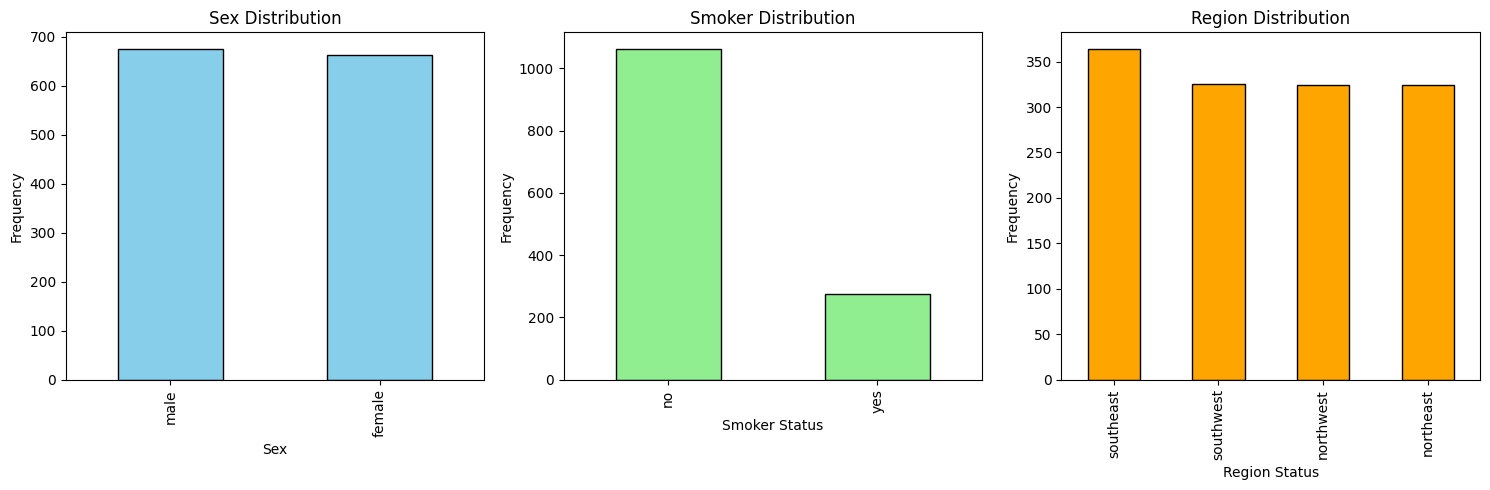

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bar plot for 'job'
df['sex'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='k')
axes[0].set_title('Sex Distribution')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Frequency')

# Bar plot for 'marital'
df['smoker'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen', edgecolor='k')
axes[1].set_title('Smoker Distribution')
axes[1].set_xlabel('Smoker Status')
axes[1].set_ylabel('Frequency')

# Bar plot for 'marital'
df['region'].value_counts().plot(kind='bar', ax=axes[2], color='orange', edgecolor='k')
axes[2].set_title('Region Distribution')
axes[2].set_xlabel('Region Status')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

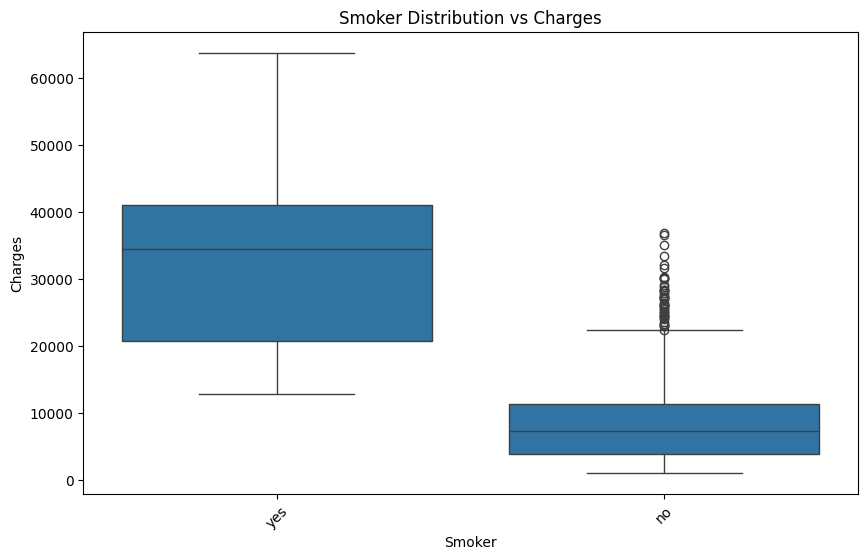

In [49]:
# Job distribution vs employment variation rate
plt.figure(figsize=(10, 6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Smoker Distribution vs Charges')
plt.xlabel('Smoker')
plt.ylabel('Charges')
plt.xticks(rotation=45)
plt.show()


In [50]:
df_nosmoke= df[df['smoker'] == 'no']

print(f"No smokers that pay over 20k: {df_nosmoke[df_nosmoke['charges']>=20000].shape[0]}")
print(f"Total no smokers: {df_nosmoke.shape[0]}")

percentage_low_20k = df_nosmoke[df_nosmoke['charges']>=20000].shape[0] / df_nosmoke.shape[0] * 100

print(f"Percentage of non-smokers that pay more than 20.000: {percentage_low_20k:.2f}% ")

No smokers that pay over 20k: 61
Total no smokers: 1063
Percentage of non-smokers that pay more than 20.000: 5.74% 


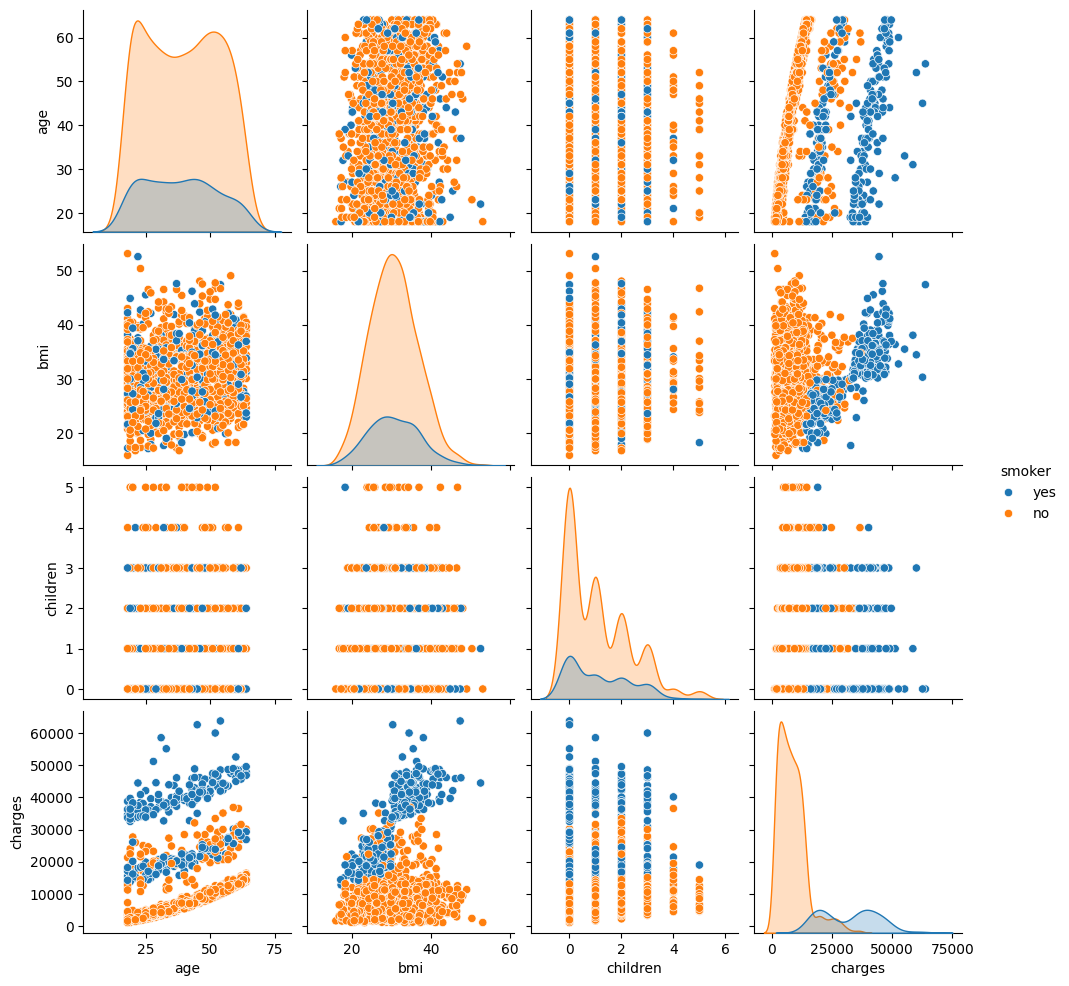

In [51]:
sns.pairplot(df, hue='smoker')
plt.show()

We can see there's a spike in the price charged after reaching BMI >= 30. Let's check how many of them we have

In [52]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [53]:
# Create interaction term between bmi and smoker
df_encoded['bmi_smoker'] = df_encoded['bmi'] * df_encoded['smoker_yes']


In [54]:
# Define features and target variable
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [55]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [56]:
# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

In [57]:
# Display the evaluation metrics
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")

Train RMSE: 4898.7002273868775
Test RMSE: 4572.811239354677
Train R-squared: 0.8247283224158267
Test R-squared: 0.8862045574393043


In [58]:
# Define features and target variable
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

In [59]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the scaled data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [60]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [61]:
# Evaluate the model
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

In [62]:
# Display the evaluation metrics
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R-squared: {train_r2}")
print(f"Test R-squared: {test_r2}")

Train RMSE: 4898.7002273868775
Test RMSE: 4572.811239354677
Train R-squared: 0.8247283224158267
Test R-squared: 0.8862045574393043


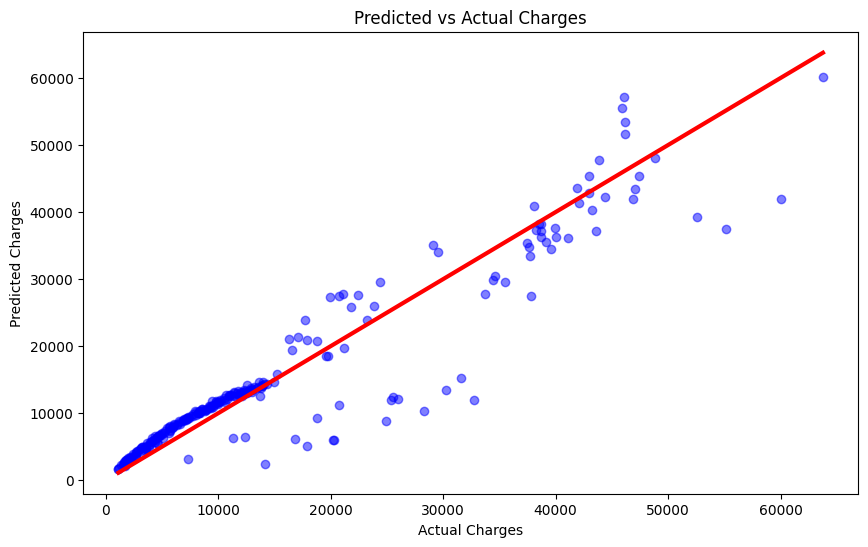

In [63]:
# Plotting predictions vs reality
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=3, color='red')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Predicted vs Actual Charges')
plt.show()

In [66]:
# Transform features into polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Split the data
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Initialize and train the model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Make predictions
y_pred_train_poly = poly_model.predict(X_train_poly)
y_pred_test_poly = poly_model.predict(X_test_poly)

# Evaluate the model
train_rmse_poly = mean_squared_error(y_train, y_pred_train_poly, squared=False)
test_rmse_poly = mean_squared_error(y_test, y_pred_test_poly, squared=False)
train_r2_poly = r2_score(y_train, y_pred_train_poly)
test_r2_poly = r2_score(y_test, y_pred_test_poly)

(train_rmse_poly, test_rmse_poly, train_r2_poly, test_r2_poly)


(4735.552318143633, 4656.442213784695, 0.83620852507452, 0.8820041438988019)

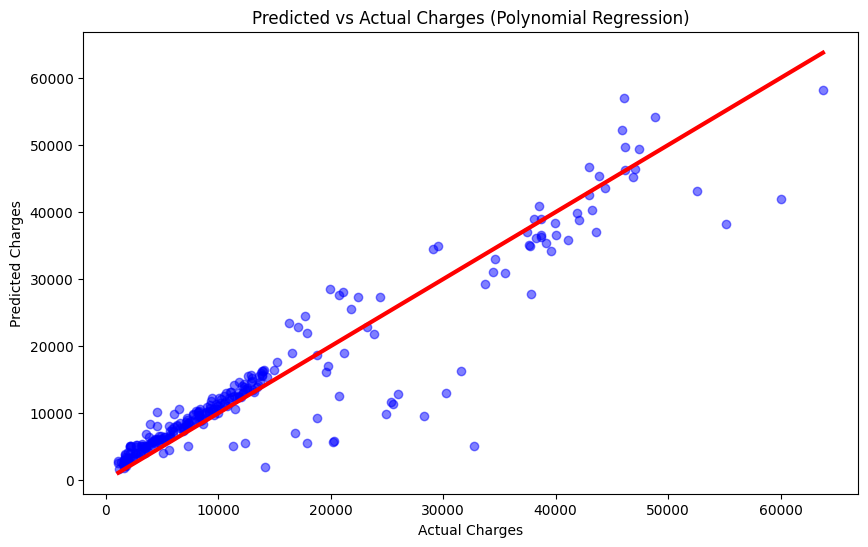

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_poly, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], lw=3, color='red')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Predicted vs Actual Charges (Polynomial Regression)')
plt.show()

In [70]:
# Define the model pipeline
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])

# Define the hyperparameters grid
param_grid = {
    'poly__degree': [1, 2, 3, 4],
    'ridge__alpha': [0.1, 1, 10, 100]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_train_best = best_model.predict(X_train)
y_pred_test_best = best_model.predict(X_test)

# Evaluate the best model
train_rmse_best = mean_squared_error(y_train, y_pred_train_best, squared=False)
test_rmse_best = mean_squared_error(y_test, y_pred_test_best, squared=False)
train_r2_best = r2_score(y_train, y_pred_train_best)
test_r2_best = r2_score(y_test, y_pred_test_best)

# Print the best parameters and evaluation metrics
(best_params, train_rmse_best, test_rmse_best, train_r2_best, test_r2_best)


({'poly__degree': 2, 'ridge__alpha': 10},
 4742.51530244095,
 4645.4190074880335,
 0.8357265048793632,
 0.8825621463555919)

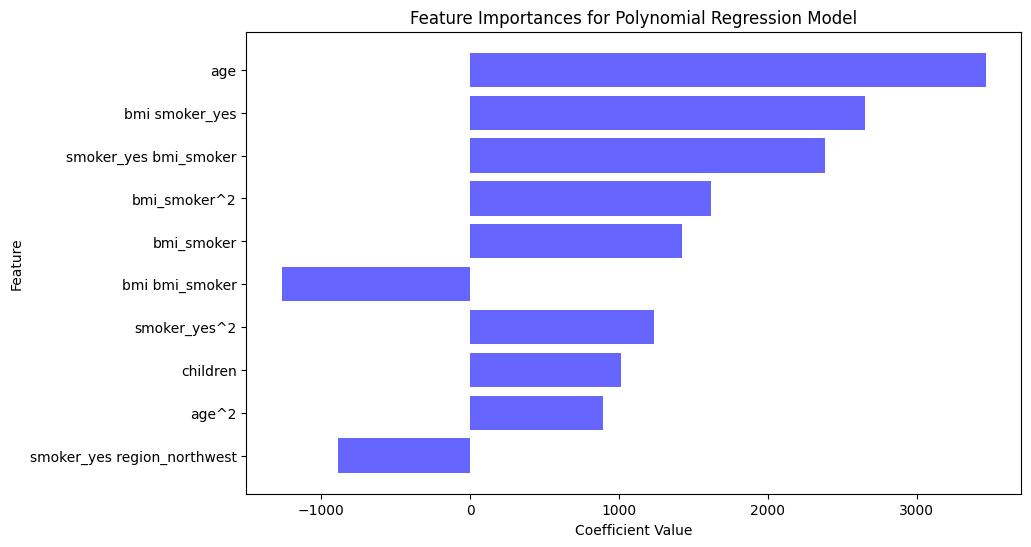

In [77]:
# Get the polynomial feature names
poly_features = poly.get_feature_names_out(X.columns)

# Get the coefficients from the best model
coefficients = best_model.named_steps['ridge'].coef_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': poly_features,
    'Coefficient': coefficients
})

# Sort the features by absolute value of coefficient
feature_importances['Abs_Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=False)
feature_importances = feature_importances.iloc[:10]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'], color='blue', alpha=0.6)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importances for Polynomial Regression Model')
plt.gca().invert_yaxis()
plt.show()

Age and smoking status (along with their interactions) are the most significant predictors, aligning with expectations that older age and smoking typically increase health risks and insurance costs.

In [80]:
# Set up the GridSearchCV with cross-validation
grid_search_cv = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV
grid_search_cv.fit(X, y)

# Get the best parameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

# Evaluate the best model using cross-validation
cv_scores = cross_val_score(best_model_cv, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = (-cv_scores)**0.5

# Print the best parameters and cross-validation results
best_params_cv, cv_rmse.mean(), cv_rmse.std()


d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.32041e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.49593e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.43656e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.51617e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Programs\Anaconda\envs\tf_gpu\lib\site-pa

({'poly__degree': 2, 'ridge__alpha': 100},
 4850.393013866225,
 375.34071071021083)

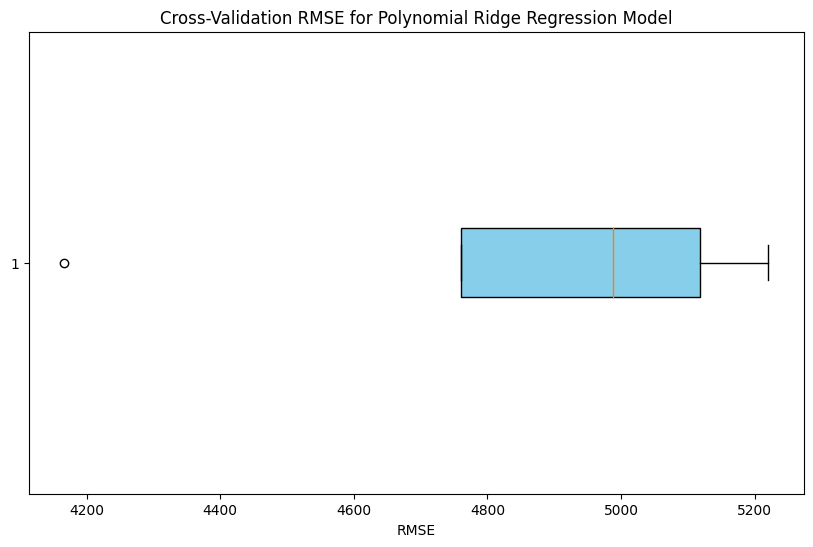

In [81]:
# Best model pipeline based on Grid Search CV
best_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_params_cv['poly__degree'], include_bias=False)),
    ('ridge', Ridge(alpha=best_params_cv['ridge__alpha']))
])

# Perform cross-validation and get the RMSE for each fold
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = (-cv_scores)**0.5

# Plotting the cross-validation results
plt.figure(figsize=(10, 6))
plt.boxplot(cv_rmse, vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('RMSE')
plt.title('Cross-Validation RMSE for Polynomial Ridge Regression Model')
plt.show()

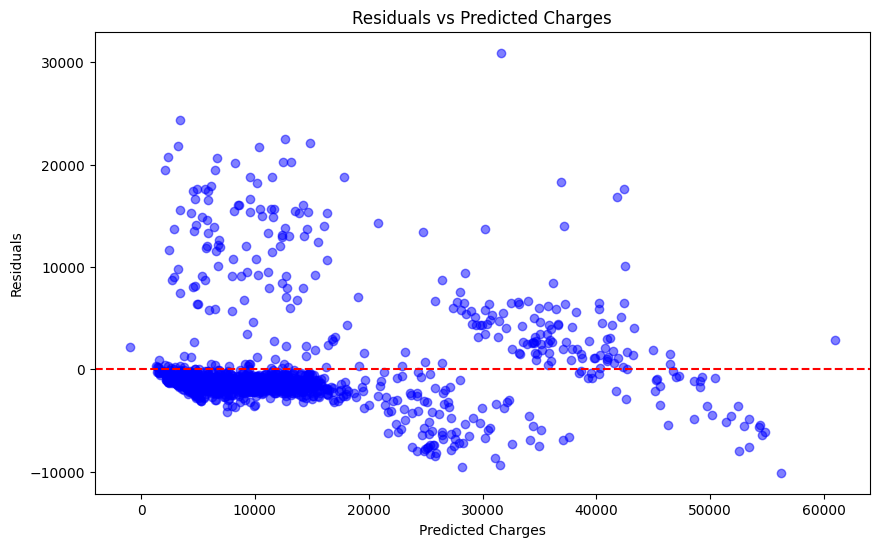

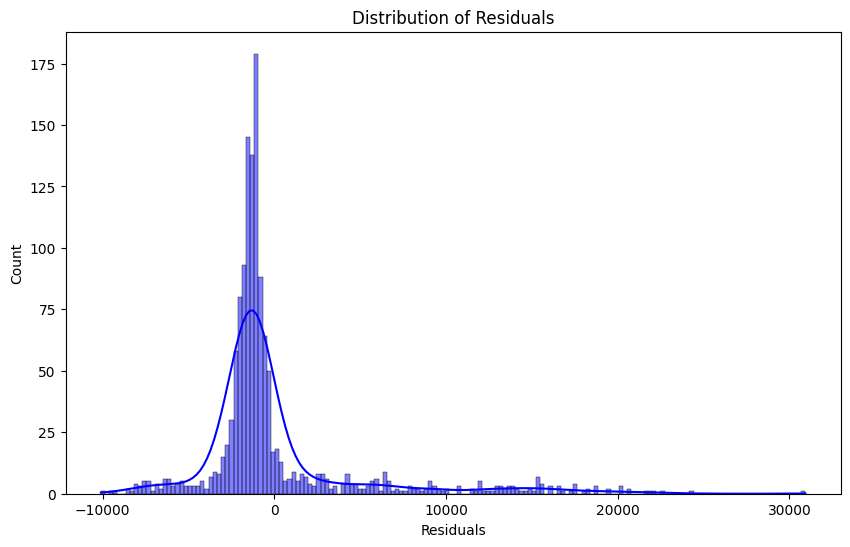

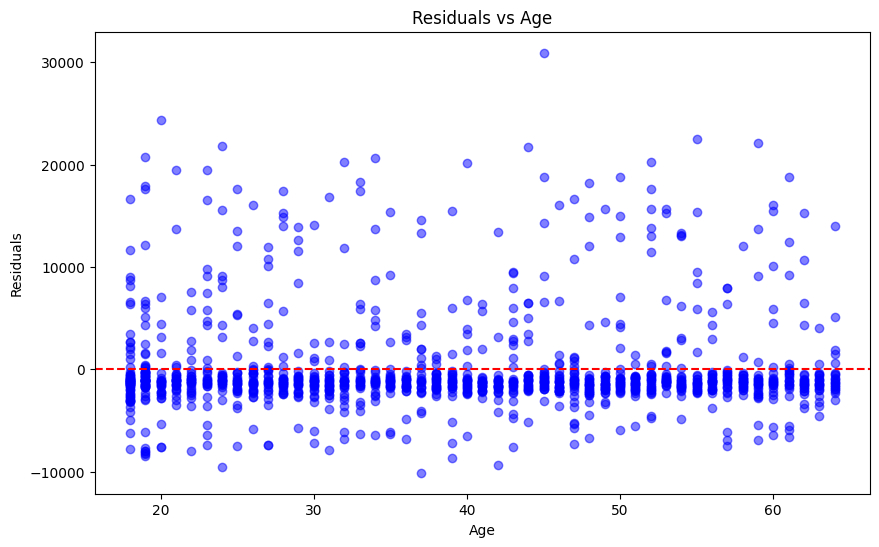

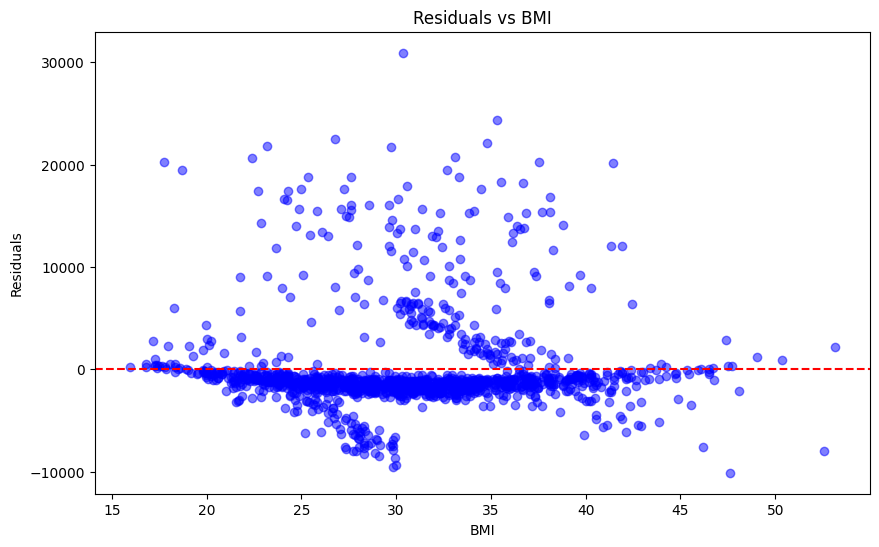

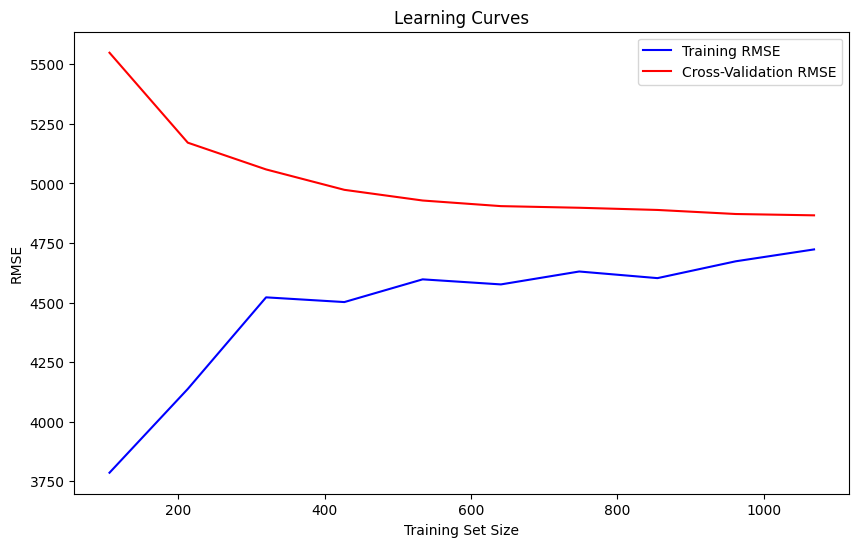

In [84]:
# Fit the model to get predictions
best_pipeline.fit(X, y)
y_pred = best_pipeline.predict(X)
residuals = y - y_pred

# Plot residuals vs predicted charges
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Charges')
plt.show()

# Plot distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

# Plot residuals vs age
plt.figure(figsize=(10, 6))
plt.scatter(df['age'], residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Age')
plt.ylabel('Residuals')
plt.title('Residuals vs Age')
plt.show()

# Plot residuals vs BMI
plt.figure(figsize=(10, 6))
plt.scatter(df['bmi'], residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('BMI')
plt.ylabel('Residuals')
plt.title('Residuals vs BMI')
plt.show()

# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_pipeline, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Convert negative MSE to positive RMSE
train_scores_mean = (-train_scores.mean(axis=1))**0.5
test_scores_mean = (-test_scores.mean(axis=1))**0.5

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training RMSE', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-Validation RMSE', color='red')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [85]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Fit the model to get predictions
best_pipeline.fit(X, y)
y_pred = best_pipeline.predict(X)
residuals = y - y_pred

# Perform Breusch-Pagan test
exog = sm.add_constant(X)  # Add a constant term for the intercept
bp_test = het_breuschpagan(residuals, exog)

# bp_test returns (Lagrange multiplier statistic, p-value, f-value, f p-value)
bp_test


(9.342235762486082,
 0.40630123287418146,
 1.0375119243624225,
 0.40743832370616606)